In [32]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import spacy
from spacy.tokens import DocBin
from spacy.matcher import Matcher
from spacy.util import filter_spans
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [43]:
data1 = pd.read_csv('Data/SEntFiN-v1.1.csv') # https://www.kaggle.com/datasets/ankurzing/aspect-based-sentiment-analysis-for-financial-news ",
data2_train = pd.read_csv('Data/sent_train.csv') # https://www.kaggle.com/datasets/borhanitrash/twitter-financial-news-sentiment-dataset",
data2_valid = pd.read_csv('Data/sent_valid.csv')
data3 = pd.read_csv('Data/data.csv') # https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis",
data4 = pd.read_csv('Data/all-data.csv', names=["sentiment", "text"], encoding="utf-8", encoding_errors="replace") # https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news1",

display(data1.head(4))
display(data2_train.head(4)) # In first rows it seemed like in each sentence contains the symbol, on further inspection it seems like the symbol is not always present.1",
display(data3.head(4))
display(data4.head(4))

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral


,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...


In [11]:
import pycountry

COMMODITY = {
    "gold", "silver", "platinum", "palladium", "copper", "aluminum", "nickel",
    "zinc", "lead", "tin", "iron ore", "steel", "cobalt", "uranium", "crude oil",
    "oil", "brent", "wti", "gasoline", "diesel", "jet fuel", "natural gas",
    "heating oil", "coal", "propane", "fuel oil", "wheat", "corn", "maize",
    "soybeans", "rapeseed", "canola", "rice", "barley", "oats", "sorghum",
    "coffee", "cocoa", "cotton", "sugar", "orange juice", "palm oil", "rubber",
    "tea", "live cattle", "lean hogs", "milk", "lumber"
}

GPE = {c.name.lower() for c in pycountry.countries}
GPE.update({"usa", "u.s.", "us", "u.k.", "uk", "europe"})

CURRENCY = {
    "dollar", "dollars", "euro", "euros", "yen", "yens", "yuan", "pound",
    "pounds", "rupee", "rupees", "franc", "francs"
}

CONCEPT = {
    "market", "markets", "stocks", "world stocks", "mid caps", "mid-cap funds",
    "equity", "equities", "bonds", "futures", "options", "ipo", "ncds", "qip",
    "gift", "experts", "investors", "promoters", "analysts", "traders",
    "farmer bodies", "indian millers", "fii", "fiis", "nifty", "sensex", "dow jones"
}

KEYWORD_RULES = {
    "COMMODITY": COMMODITY,
    "GPE": GPE,
    "CURRENCY": CURRENCY,
    "CONCEPT": CONCEPT
}

# Heuristic function to identify people's names
def is_likely_person(name: str) -> bool:
    parts = name.strip().split()
    if len(parts) != 2: return False
    if parts[0].isupper() and parts[1].isupper(): return False
    return parts[0].istitle() and parts[1].istitle()

# Main function to determine the label for any given name
def get_entity_label(name: str) -> str:
    name_lower = name.lower().strip()
    for label, keywords in KEYWORD_RULES.items():
        if name_lower in keywords:
            return label
    if is_likely_person(name):
        return "PERSON"
    return "COMPANY" # Fallback label

In [12]:
nlp = spacy.load("en_core_web_sm")
TRAIN_DATA = []

for _, row in data1.iterrows():
    title = row['Title']
    decision_dict = eval(row['Decisions'])
    
    entities_to_find = {name: get_entity_label(name) for name in decision_dict.keys()}
    
    entities_for_this_title = []
    with nlp.select_pipes(disable="ner"):
        doc = nlp(title)

    for name, label in entities_to_find.items():
        matcher = Matcher(nlp.vocab)
        # Using .strip() and LOWER for robust matching
        pattern = [{"LOWER": token.lower_} for token in nlp(name.strip())]
        matcher.add("ENTITY_PATTERN", [pattern])
        matches = matcher(doc)
        
        for match_id, start_token, end_token in matches:
            span = doc[start_token:end_token]
            entity = (span.start_char, span.end_char, label)
            entities_for_this_title.append(entity)

    if entities_for_this_title:
        spans = [doc.char_span(s, e, label=l) for s, e, l in set(entities_for_this_title) if doc.char_span(s, e, label=l) is not None]
        filtered_spans = filter_spans(spans)
        final_entities = [(span.start_char, span.end_char, span.label_) for span in filtered_spans]
        TRAIN_DATA.append((title, {"entities": final_entities}))
train_data, dev_data = train_test_split(TRAIN_DATA, test_size=0.2, random_state=42)

def create_spacy_files(data, output_path):
    db = DocBin()
    for text, annot in data:
        doc = nlp.make_doc(text)
        doc.ents = [doc.char_span(s, e, label=l, alignment_mode="contract") for s, e, l in annot["entities"]]
        db.add(doc)
    db.to_disk(output_path)


create_spacy_files(train_data, "./Data/train.spacy")
create_spacy_files(dev_data, "./Data/dev.spacy")
print(f"Total examples: {len(TRAIN_DATA)}, Training: {len(train_data)}, Dev: {len(dev_data)}")

Total examples: 10687, Training: 8549, Dev: 2138


'python -m spacy train config_trf.cfg --output ./output_trf --gpu-id 0'

In [19]:
import random

model_path = "output/model-best"

nlp_trained = spacy.load(model_path)

dev_file = "./Data/dev.spacy"
doc_bin = DocBin().from_disk(dev_file)
validation_data = []
for doc in doc_bin.get_docs(nlp.vocab):
    entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    validation_data.append((doc.text, {"entities": entities}))

mistakes = []
for text, annotations in validation_data:
    doc_predicted = nlp_trained(text)
    true_entities = set(annotations['entities'])
    predicted_entities = set((ent.start_char, ent.end_char, ent.label_) for ent in doc_predicted.ents)
    
    if true_entities != predicted_entities:
        mistakes.append({
            "text": text,
            "true_entities": true_entities,
            "predicted_entities": predicted_entities
        })

print(f"Found {len(mistakes)} sentences with prediction errors out of {len(validation_data)}.")

print("\n--- Reviewing 5 Random Mistakes ---")
if mistakes:
    for item in random.sample(mistakes, min(5, len(mistakes))):
        print("\nTEXT:", item['text'])
        print(f"TRUE: {item['true_entities']}")
        print(f"PREDICTED: {item['predicted_entities']}")
else:
    print("No mistakes found on the dev set!")

Found 557 sentences with prediction errors out of 2138.

--- Reviewing 5 Random Mistakes ---

TEXT: Investors turn focus to proxy benchmark government bond maturing in 2028
TRUE: {(40, 55, 'COMPANY')}
PREDICTED: set()

TEXT: HDFC, HDFC Bank rally on hopes ahead of MSCI review
TRUE: {(40, 44, 'COMPANY'), (0, 4, 'COMPANY'), (6, 15, 'COMPANY')}
PREDICTED: {(0, 4, 'COMPANY'), (6, 15, 'COMPANY')}

TEXT: Sovereign gold bond scheme more likely to succeed, says Nomura report
TRUE: {(10, 19, 'COMPANY')}
PREDICTED: {(56, 62, 'COMPANY'), (10, 19, 'COMPANY')}

TEXT: AirAsia offers 2 mn cheap tickets, fly from Kolkata to Bangkok for Rs 3,300
TRUE: {(0, 7, 'COMPANY')}
PREDICTED: {(0, 7, 'COMPANY'), (55, 62, 'COMPANY')}

TEXT: Cover up all positions for SBI: Mitesh Thacker
TRUE: {(27, 30, 'COMPANY')}
PREDICTED: {(0, 5, 'COMPANY'), (27, 30, 'COMPANY')}


### en_core_web_trf fast with 557 errors on 2138, score: 0.87
### RoBERTa slow with 98 errors on 2138, score: 0.90

In [26]:
import ast
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [61]:
df1 = data1.rename(columns={'Title': 'text'})
df1['label'] = df1['Decisions'].apply(lambda x: list(ast.literal_eval(x).values())[0])
df1 = df1[['text', 'label']]

#df2_test = data2_train.copy() # Use .copy() to avoid SettingWithCopyWarning
#df2_valid = data3.copy()
#df2 = pd.concat([df2_test, df2_valid], ignore_index=True)
df2 = data2_train.copy()
df2['label'] = df2['label'].map({0: 'negative', 1: 'positive', 2: 'neutral'})
df2 = df2[['text', 'label']]

df3 = data3.rename(columns={'Sentence': 'text', 'Sentiment': 'label'})[['text', 'label']]
df4 = data4.rename(columns={'sentiment': 'label'})[['text', 'label']]

df_combined = pd.concat([df1, df2, df3, df4], ignore_index=True).dropna(subset=['text', 'label'])

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_combined['cleaned_text'] = df_combined['text'].apply(clean_text)

# Create the numeric 'target' column with your specified mapping
label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
df_combined['target'] = df_combined['label'].map(label_map)

# Drop any rows where a label might not have been in our map
df_combined.dropna(subset=['target'], inplace=True)
df_combined['target'] = df_combined['target'].astype(int)

print(df_combined[['cleaned_text', 'label', 'target']].head())
print(f"Total samples after cleaning: {len(df_combined)}")

                                        cleaned_text     label  target
0      spicejet to issue crore warrants to promoters   neutral       2
1                        mmtc q net loss at rs crore   neutral       2
2     midcap funds can deliver more stay put experts  positive       1
3             mid caps now turn into market darlings  positive       1
4  market seeing patience if not conviction praka...   neutral       2
Total samples after cleaning: 30984


In [62]:
X = df_combined['cleaned_text']
y = df_combined['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=50,
    stratify=y
)
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [63]:
svm_model = LinearSVC(random_state=42, C=1.0, max_iter=2000)
print("\n--- Training the Linear SVM model ---")
svm_model.fit(X_train_tfidf, y_train)
print("Training complete!")


--- Training the Linear SVM model ---
Training complete!



--- Evaluating the SVM model ---
Target names for report: ['negative', 'positive', 'neutral']

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.59      0.64      1209
    positive       0.74      0.72      0.73      1862
     neutral       0.78      0.84      0.81      3126

    accuracy                           0.76      6197
   macro avg       0.74      0.72      0.73      6197
weighted avg       0.75      0.76      0.75      6197


Confusion Matrix:


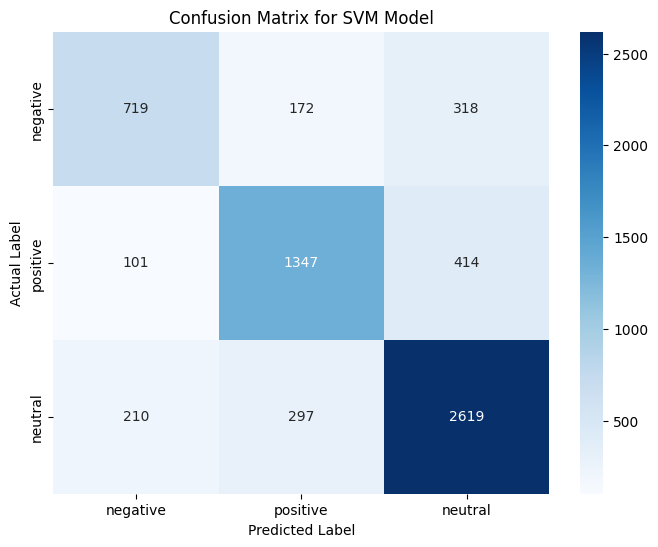

In [64]:
print("\n--- Evaluating the SVM model ---")
y_pred = svm_model.predict(X_test_tfidf)
target_names = [name for name, num in sorted(label_map.items(), key=lambda item: item[1])]
print("Target names for report:", target_names) # Should be ['negative', 'positive', 'neutral']

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for SVM Model')
plt.show()

In [65]:
final_svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),
    ('classifier', LinearSVC(random_state=42, C=1.0, max_iter=2000))
])

# Retrain on all data
final_svm_pipeline.fit(X, y)

# Create the reverse map to convert numeric predictions back to strings
reverse_label_map = {v: k for k, v in label_map.items()}

def predict_sentiment_svm(text):
    prediction_numeric = final_svm_pipeline.predict([text])[0]
    return reverse_label_map[prediction_numeric]

# Test it
test_phrase = "The company's revenue has increased significantly, beating all expectations."
sentiment = predict_sentiment_svm(test_phrase)
print(f"Phrase: '{test_phrase}'\nPredicted Sentiment: {sentiment}\n")

Phrase: 'The company's revenue has increased significantly, beating all expectations.'
Predicted Sentiment: positive



In [70]:
valid_df = pd.read_csv('Data/sent_valid.csv')
valid_df['cleaned_text'] = valid_df['text'].apply(clean_text)
X_valid = valid_df['cleaned_text']
y_valid = valid_df['label']

valid_df.dropna(subset=['text', 'label'], inplace=True)
X_valid = valid_df['cleaned_text']
y_valid = valid_df['label'].astype(int)

print(valid_df[['cleaned_text', 'label']].head())

                                    cleaned_text  label
0                   ally financial pulls outlook      0
1  dell hpe targets trimmed on compute headwinds      0
2            moodys turns negative on party city      0
3                     deutsche bank cuts to hold      0
4                     compass point cuts to sell      0


In [71]:
y_pred_valid = final_svm_pipeline.predict(X_valid)

print("\n--- Predictions Made ---")
print("True Labels (y_valid):    ", y_valid.values)
print("Predicted Labels (y_pred):", y_pred_valid)


--- Predictions Made ---
True Labels (y_valid):     [0 0 0 ... 2 2 2]
Predicted Labels (y_pred): [2 0 0 ... 2 2 2]


In [ ]:
num_errors = np.sum(y_pred_valid != y_valid.values)
total_samples = len(valid_df)

print(f"model made {num_errors} errors out of {total_samples} validation samples.")

# Calculate and print standard metrics
accuracy = accuracy_score(y_valid, y_pred_valid)
print(f"Validation Accuracy: {accuracy:.2%}")

target_names = [name for name, num in sorted(label_map.items(), key=lambda item: item[1])]
print("\nValidation Classification Report:")
print(classification_report(y_valid, y_pred_valid, target_names=target_names, zero_division=0))

print("\n--- Detailed Error Analysis ---")
# Add the predictions back to the validation dataframe
valid_df['predicted_label_numeric'] = y_pred_valid

# Use the reverse map to get string representations for easy reading
reverse_label_map = {v: k for k, v in label_map.items()}
valid_df['true_label_str'] = valid_df['label'].map(reverse_label_map)
valid_df['predicted_label_str'] = valid_df['predicted_label_numeric'].map(reverse_label_map)

# Filter for rows where the numeric prediction was wrong
error_df = valid_df[valid_df['label'] != valid_df['predicted_label_numeric']]

if error_df.empty:
    print("No errors found on the validation set. Great job!")
else:
    print("The following predictions were incorrect:")
    # Show the original text, the true label (as text), and the predicted label (as text)
    print(error_df[['text', 'true_label_str', 'predicted_label_str']])


--- MODEL VALIDATION RESULTS ---
The model made 476 errors out of 2388 validation samples.
Validation Accuracy: 80.07%

Validation Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.57      0.64       347
    positive       0.67      0.70      0.68       475
     neutral       0.86      0.88      0.87      1566

    accuracy                           0.80      2388
   macro avg       0.75      0.72      0.73      2388
weighted avg       0.80      0.80      0.80      2388


--- Detailed Error Analysis ---
The following predictions were incorrect:
                                                   text true_label_str  \
0     $ALLY - Ally Financial pulls outlook https://t...       negative   
5     $TAP - Barclays cools on Molson Coors https://...       negative   
7     Analysts Eviscerate Musk's Cybertruck: "0% Of ...       negative   
8     Barclays assigns only a 20% chance that studie...       negative   
13    Goldman pulls